100%|██████████| 9.91M/9.91M [00:00<00:00, 12.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.14MB/s]


Epoch 01 | LR=1.0e-04 | Δtr=-5.34e-04 | Δval=-5.33e-04 | Phase=progress
Epoch 02 | LR=1.0e-03 | Δtr=-5.29e-03 | Δval=-5.28e-03 | Phase=progress
Epoch 03 | LR=1.0e-02 | Δtr=-5.43e-02 | Δval=-5.41e-02 | Phase=progress
Epoch 04 | LR=1.0e-01 | Δtr=-6.55e-01 | Δval=-6.49e-01 | Phase=progress
Epoch 05 | LR=1.0e-01 | Δtr=-3.63e-01 | Δval=-3.49e-01 | Phase=progress
Epoch 06 | LR=1.0e-01 | Δtr=-1.71e-01 | Δval=-1.41e-01 | Phase=progress
Epoch 07 | LR=1.0e-01 | Δtr=-1.13e-01 | Δval=-1.10e-01 | Phase=progress
Epoch 08 | LR=1.0e-01 | Δtr=-7.07e-02 | Δval=-2.61e-02 | Phase=progress
Epoch 09 | LR=1.0e-01 | Δtr=-8.43e-02 | Δval=-7.53e-02 | Phase=progress
Epoch 10 | LR=1.0e-01 | Δtr=-3.47e-02 | Δval=-1.93e-02 | Phase=progress
Epoch 11 | LR=1.0e-01 | Δtr=-1.58e-02 | Δval=1.26e-02 | Phase=overfit
Epoch 12 | LR=1.0e-01 | Δtr=-9.06e-02 | Δval=-5.17e-02 | Phase=progress
Epoch 13 | LR=1.0e-01 | Δtr=-4.34e-02 | Δval=-6.30e-02 | Phase=progress
Epoch 14 | LR=1.0e-01 | Δtr=-3.39e-02 | Δval=6.95e-03 | Phase=over

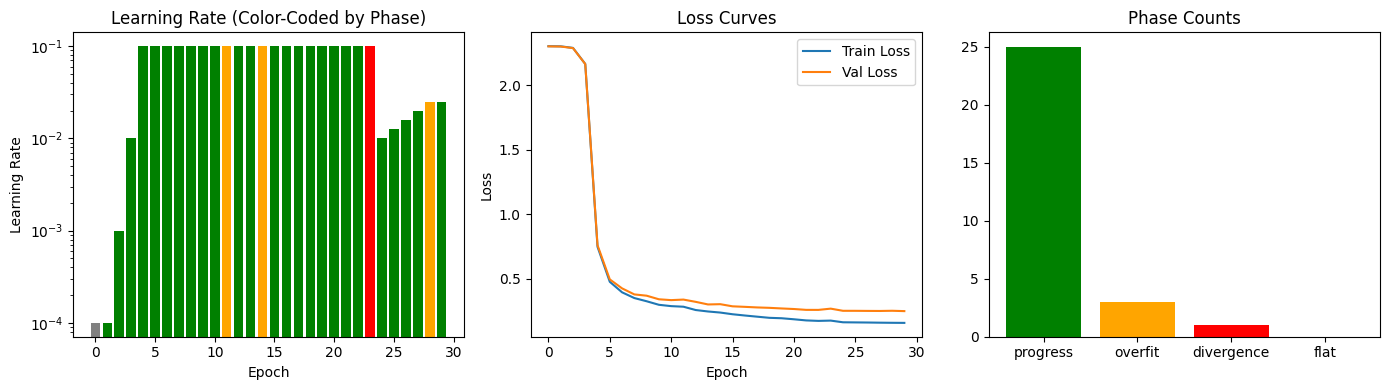

In [ ]:
# LG-XLR on MNIST (subset): Visualization + Phase Detection
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Seed and Device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST Subset
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Use only 10,000 samples for speed
subset_indices = list(range(10000))
train_val_subset = Subset(mnist, subset_indices)
train_len = int(0.8 * len(train_val_subset))
val_len = len(train_val_subset) - train_len
train_data, val_data = random_split(train_val_subset, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)

# Define MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

# Loss
criterion = nn.CrossEntropyLoss()

# Evaluate
def evaluate(model, loader):
    model.eval()
    total_loss, correct, n = 0.0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            total_loss += criterion(out, y).item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            n += x.size(0)
    return total_loss / n, correct / n

# LG-XLR Constants
Lo, Uo = -4, -1
S0, H, Cmax = 1, 1e-4, 2
L, U, S, C = Lo, Uo, S0, 0
epochs = 30

# Tracking
lr_history = []
phase_labels = []
train_loss_hist, val_loss_hist = [], []

# Init model
model = MLP().to(device)

for epoch in range(epochs):
    lr = 10 ** L
    optimizer = optim.SGD(model.parameters(), lr=lr)
    model.train()

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    # Evaluate
    train_loss, _ = evaluate(model, train_loader)
    val_loss, _ = evaluate(model, val_loader)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    lr_history.append(lr)

    # Detect Phase
    if epoch == 0:
        phase_labels.append("init")
        continue

    Δtr = (train_loss - train_loss_hist[-2]) / train_loss_hist[-2]
    Δval = (val_loss - val_loss_hist[-2]) / val_loss_hist[-2]

    if Δtr <= -H and Δval <= -H:
        L = min(L + S, U)
        C = 0
        phase_labels.append("progress")
    elif Δtr >= H and Δval >= H:
        U = L
        L = max(L - S, Lo)
        S = S / 10
        C = 0
        model.load_state_dict(prev_weights)
        phase_labels.append("divergence")
    elif Δtr <= -H and Δval >= H:
        C += 1
        if C > Cmax:
            U = L
            L = max(L - S0, Lo)
            S = S / 10
            C = 0
            model.load_state_dict(prev_weights)
        phase_labels.append("overfit")
    else:
        phase_labels.append("flat")

    prev_weights = model.state_dict()
    if L == U == Lo:
        print(f"Early stop at epoch {epoch}")
        break

    print(f"Epoch {epoch:02d} | LR={lr:.1e} | Δtr={Δtr:.2e} | Δval={Δval:.2e} | Phase={phase_labels[-1]}")

# Phase → color
color_map = {"init": "gray", "progress": "green", "divergence": "red", "overfit": "orange", "flat": "blue"}
colors = [color_map[p] for p in phase_labels]

# Plots
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.bar(range(len(lr_history)), lr_history, color=colors)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate (Color-Coded by Phase)")

plt.subplot(1, 3, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 3, 3)
phases = ["progress", "overfit", "divergence", "flat"]
counts = [phase_labels.count(p) for p in phases]
plt.bar(phases, counts, color=[color_map[p] for p in phases])
plt.title("Phase Counts")

plt.tight_layout()
plt.show()
